# Sample Model Evaluation Pipeline

In [181]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder

In [182]:
import cml.data_v1 as cmldata

CONNECTION_NAME = "default-hive"
conn = cmldata.get_connection(CONNECTION_NAME)

## Sample Usage to get pandas data frame
EXAMPLE_SQL_QUERY = "show databases"
dataframe = conn.get_pandas_dataframe(EXAMPLE_SQL_QUERY)
print(dataframe)

## Other Usage Notes:

## Alternate Sample Usage to provide different credentials as optional parameters
#conn = cmldata.get_connection(
#    CONNECTION_NAME, {"USERNAME": "someuser", "PASSWORD": "somepassword"}
#)

## Alternate Sample Usage to get DB API Connection interface
#db_conn = conn.get_base_connection()

## Alternate Sample Usage to get DB API Cursor interface
#db_cursor = conn.get_cursor()
#db_cursor.execute(EXAMPLE_SQL_QUERY)
#for row in db_cursor:
#  print(row)

               database_name
0                    airline
1   airline_ontime_parquet_v
2                airlinedata
3                   airlines
4                       amex
5                     bhagan
6                   bronzedb
7                        cdc
8                       cnav
9                    default
10             demo_accounts
11            demo_datacards
12               demo_people
13              demo_staging
14                   factory
15              finance_demo
16                 frb_demos
17        information_schema
18                       iot
19                    newjar
20               nhs_iceberg
21                parma_demo
22              pharmalytics
23                   pkptest
24             prescribing_p
25           prescribing_p_e
26                    retail
27           rfro_emp_gov_db
28                  sensordb
29                  silverdb
30                 sled_east
31                       sys
32                    testdb
33            

In [183]:
EXAMPLE_SQL_QUERY = "select *\
                    from default.marketing_campaign_table as m\
                    inner join default.bank_info_table as b\
                    on m.name = b.name"

df = conn.get_pandas_dataframe(EXAMPLE_SQL_QUERY)

#### Why not load the dataframes into Pandas and join via Pandas SQL? The query is running in Hive, achieving dramatically higher scalability

In [184]:
df.head()

,m.name,m.street_address,m.city,m.postcode,m.phone_number,m.job,b.name,b.aba_routing,b.bank_country,b.account_number,...,b.recency,b.history,b.used_discount,b.used_bogo,b.zip_code,b.is_referral,b.channel,b.offer,b.conversion,b.score
0,name,c8b3d31dc63ccc840b973b7239399a6cbe70f595706a75...,city,postcode,phone_number,job,name,ABA_routing,bank_country,account_number,...,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,score
1,Traci Collins,b14484ae2a0d93c30f55039277fbf1ac48a11f93dbe45a...,West Gabriela,82688,+1-478-398-3203x469,Farm manager,Traci Collins,053883643,GB,CNPE18207573041375,...,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,1.2883397418200806
2,Yvonne Newton,d570b823dea91a56b93d09ffdb04d3c5c470639e880b06...,Pottsmouth,31772,(960)603-6284x03255,Event organiser,Yvonne Newton,108333666,GB,GIEO50560797726591,...,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1,2.261725144709028
3,Danielle Lynn,d9f37992937b6d08b244ed28e3011692bd9af20a8a48e4...,Tiffanyborough,07747,812.516.4983x88808,"""Designer",Danielle Lynn,103872407,GB,NWHB22938746965213,...,1,211.45,0,1,Urban,1,Phone,Buy One Get One,0,0.6887069692398109
4,Jody Salazar,5e9a9f01ae924f20255ee79d8cb9a14c147ab4055b931a...,New Brian,53616,817.363.5697,Ergonomist,Jody Salazar,098871461,GB,RRAC70141970881669,...,5,642.9,0,1,Surburban,1,Multichannel,Buy One Get One,0,1.0046643957084096


In [7]:
df.dtypes

m.name              object
m.street_address    object
m.city              object
m.postcode          object
m.phone_number      object
m.job               object
b.name              object
b.aba_routing       object
b.bank_country      object
b.account_number    object
b.iban              object
b.swift11           object
b.recency           object
b.history           object
b.used_discount     object
b.used_bogo         object
b.zip_code          object
b.is_referral       object
b.channel           object
b.offer             object
b.conversion        object
b.score             object
dtype: object

In [25]:
df = df.iloc[1:]

In [33]:
df.describe()

,m.name,m.street_address,m.city,m.postcode,m.phone_number,m.job,b.name,b.aba_routing,b.bank_country,b.account_number,...,b.recency,b.history,b.used_discount,b.used_bogo,b.zip_code,b.is_referral,b.channel,b.offer,b.conversion,b.score
count,265,265,265,265,265,265,265,265,265,265,...,265,265,265,265,265,265,265,265,265,265
unique,256,259,255,259,259,186,256,256,1,256,...,12,228,2,2,3,2,3,3,2,259
top,Sandra Morales,6548 Natasha Loaf Suite 855,Rachelbury,06017,284.697.3724x94974,"""Designer",Sandra Morales,016410477,GB,MKDD53907988188069,...,1,29.99,1,1,Surburban,0,Web,No Offer,0,0.6420108458187197
freq,4,2,2,2,2,11,4,4,265,4,...,41,33,154,138,122,134,126,94,239,2


In [66]:
baseline_df = df[["m.job","b.recency", "b.used_discount", "b.used_bogo", "b.zip_code", "b.is_referral", "b.channel", "b.offer", "b.score", "b.conversion"]] 

In [79]:
baseline_df = baseline_df.astype({"m.job":"string", 
                                  "b.recency":"int64", 
                                  "b.used_discount":"int64", 
                                  "b.used_bogo":"int64",
                                  "b.zip_code":"string", 
                                  "b.is_referral":"int64", 
                                  "b.channel":"string", 
                                  "b.offer":"string", 
                                  "b.score":"float64",
                                  "b.conversion":"int64"})

In [80]:
baseline_df.head()

,m.job,b.recency,b.used_discount,b.used_bogo,b.zip_code,b.is_referral,b.channel,b.offer,b.score,b.conversion
1,Farm manager,2,1,0,Urban,0,Web,Buy One Get One,1.288340,0
2,Event organiser,6,0,1,Surburban,0,Phone,Buy One Get One,2.261725,1
3,"""Designer",1,0,1,Urban,1,Phone,Buy One Get One,0.688707,0
4,Ergonomist,5,0,1,Surburban,1,Multichannel,Buy One Get One,1.004664,0
5,Brewing technologist,5,1,0,Surburban,0,Phone,Discount,0.821603,0


In [81]:
baseline_df.dtypes

m.job               string
b.recency            int64
b.used_discount      int64
b.used_bogo          int64
b.zip_code          string
b.is_referral        int64
b.channel           string
b.offer             string
b.score            float64
b.conversion         int64
dtype: object

##### Simple Data Viz

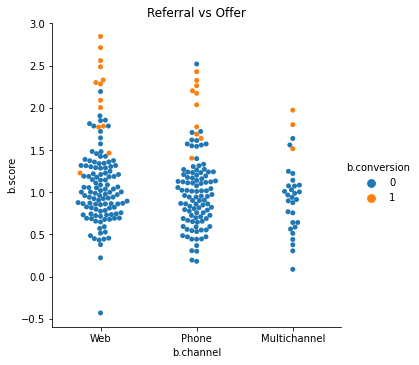

In [91]:
sns.catplot(x="b.channel", y="b.score", hue="b.conversion", kind="swarm", data=baseline_df).set(title='Referral vs Offer')
plt.show()

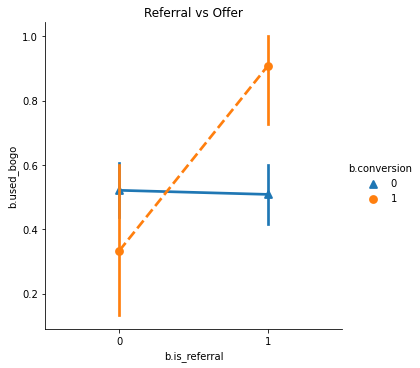

In [89]:
sns.catplot(x="b.is_referral", y="b.used_bogo", hue="b.conversion",
            markers=["^", "o"], linestyles=["-", "--"],
            kind="point", data=baseline_df).set(title='Referral vs Offer')
plt.show()

##### Investigating Target Class Imbalance

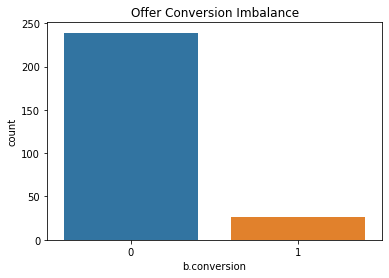

In [93]:
sns.countplot(x="b.conversion", data=df).set(title='Offer Conversion Imbalance')
plt.show()

Building a Model Evaluation Pipeline

In [99]:
#Split data between training and test sets
def split_data(df, target_name, test_size):
    
    y = df[target_name]
    X = df.drop(target_name, axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = 1)

    return X_train, X_test, y_train, y_test

In [150]:
def create_pipeline(clf):
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', RobustScaler())])
    
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer, numeric_features),
                      ('cat', cat_transformer, cat_features),], remainder='passthrough')
    
    clf_name = type(clf).__name__

    # Append classifier to preprocessing pipeline.
    pipe = Pipeline(steps=[('preprocessor', preprocessor),(clf_name, clf)])

    return pipe

In [151]:
def test_model(clfs, df, y_name, scoring_metric):
    
    X_train, X_test, y_train, y_test = split_data(df, y_name, 0.33)
    
    cv_results = {}
    test_results = {}
    best_estimators = {}
    
    #Iterate through each model:
    for clf in clfs.items():
        
        pipe = create_pipeline(clf[0])
    
        gs = GridSearchCV(pipe, param_grid=clf[1], cv=5, scoring=scoring_metric, n_jobs=-1)
        
        gs.fit(X_train,y_train)
        
        cv_metric = cross_val_score(gs, X_train, y_train, cv=3)
        
        test_score = gs.score(X_test, y_test)
        
        best_estimators[type(clf[0]).__name__] = gs.best_estimator_
        
        cv_results[type(clf[0]).__name__] = cv_metric
        
        test_results[type(clf[0]).__name__] = test_score
    
    return cv_results, test_results, best_estimators

In [152]:
clfs = {
        AdaBoostClassifier(DecisionTreeClassifier(max_depth = 5, max_features=10, class_weight='balanced'))
                                            :{
                                            'AdaBoostClassifier__learning_rate':[0.6, 0.9],
                                            'AdaBoostClassifier__n_estimators':[10]},
        
        RandomForestClassifier():{
                                            'RandomForestClassifier__max_depth':[10], 
                                            'RandomForestClassifier__min_samples_leaf':[20000],
                                            'RandomForestClassifier__min_samples_split':[10000], 
                                            'RandomForestClassifier__class_weight':['balanced'], 
                                            'RandomForestClassifier__n_estimators':[10]}
        }

In [153]:
X_train, X_test, y_train, y_test = split_data(baseline_df, 'b.conversion', 0.3)

In [154]:
numeric_features = list(baseline_df.select_dtypes(include=['int', 'float']).columns)
numeric_features.remove('b.conversion')

In [155]:
cat_features = list(baseline_df.select_dtypes(exclude=['int', 'float']).columns)
#cat_features.remove('b.conversion')

In [149]:
#cat_features + numeric_features

In [156]:
cv_results, test_results, best_estimators = test_model(clfs, baseline_df, 'b.conversion', 'accuracy')

In [158]:
#Simple visualization of outcomes:
def visualize_results(results):
    
    res = pd.DataFrame(results).round(4)
    
    fig, ax1 = plt.subplots(figsize=(len(res.columns)*3,4))
    sns.boxplot(data=res, ax=ax1)
    plt.suptitle('Model Evaluation Report')
    plt.show()

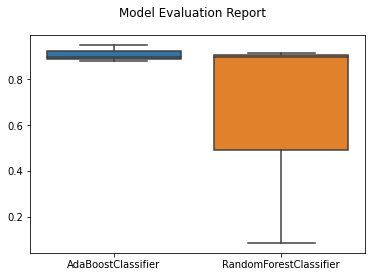

In [160]:
visualize_results(cv_results)

In [162]:
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassificationReport, PrecisionRecallCurve, ConfusionMatrix

In [163]:
def conf_matrix(clf, X_train, X_test, y_train, y_test):
    fig, ax = plt.subplots(figsize=(8,5))

    cm = ConfusionMatrix(clf, classes=[0,1], ax=ax)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)

    ax.set(title='GBM Confusion Matrix', xlabel='Predicted Class', ylabel='True Class')

    cm.poof()

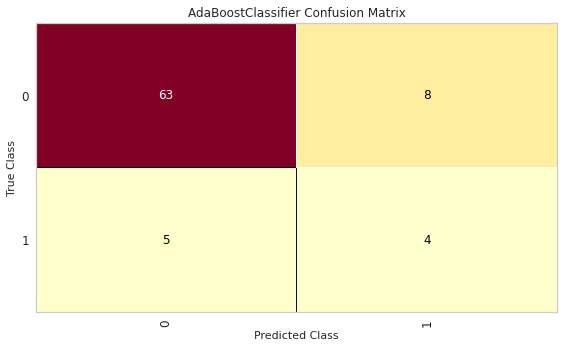

In [170]:
conf_matrix(best_estimators['AdaBoostClassifier'], X_train, X_test, y_train, y_test)

In [165]:
def val_curves(clf, param_name, param_range, cv, X_train, y_train, scoring):

    fig, ax = plt.subplots(figsize=(8,4))

    viz_vc_bg = ValidationCurve(
                    clf, param_name=param_name,
                    param_range=param_range, cv=cv, 
                    scoring=scoring, ax=ax)

    viz_vc_bg.fit(X_train, y_train)
    
    clf_name = type(clf).__name__
    title = "Validation Curves for: {}".format(clf_name)
    
    ax.set(title=title, ylabel='Score')
    ax.legend().set_visible(True)

    viz_vc_bg.poof()

In [166]:
def learn_curves(clf, cv, X_train, y_train, scoring):

    fig, ax = plt.subplots(figsize=(8,4))

    viz_lc_bg = LearningCurve(clf, train_sizes = np.linspace(0.1, 1.0, 10), 
                              scoring=scoring, cv=cv, ax=ax)

    # Fit and poof the visualizer
    viz_lc_bg.fit(X_train, y_train)

    ax.set(title='Learning Curves', xlabel='Training Instances', ylabel='Score')

    ax.legend().set_visible(True)

    viz_lc_bg.poof()

/home/cdsw/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:607: RuntimeWarning: overflow encountered in exp
  estimator_weight * ((sample_weight > 0) | (estimator_weight < 0))
/home/cdsw/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:486: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/home/cdsw/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:607: RuntimeWarning: overflow encountered in exp
  estimator_weight * ((sample_weight > 0) | (estimator_weight < 0))
/home/cdsw/.local/lib/python3.7/site-packages/sklearn/ensemble/_weight_boosting.py:486: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return super().fit(X, y, sample_weight)
/home/cdsw/.local/lib/python3.7/site-packages/sklear

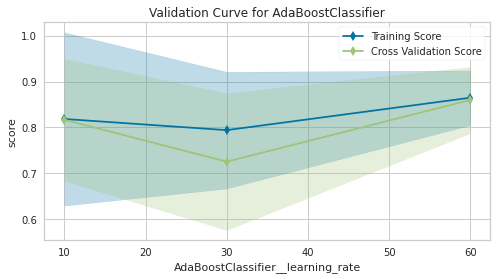

In [172]:
val_curves(best_estimators['AdaBoostClassifier'], 
           'AdaBoostClassifier__learning_rate', [10, 30, 60], 3, X_train, y_train, 'accuracy')

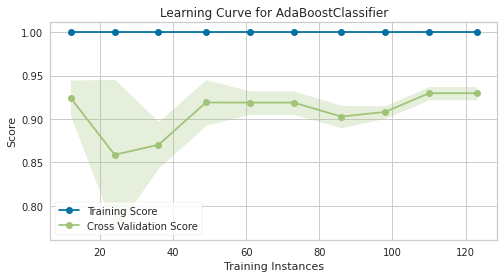

In [174]:
learn_curves(best_estimators['AdaBoostClassifier'], 3, X_train, y_train, 'accuracy')

In [175]:
import pickle

In [180]:
filename = 'models/adaboost.joblib'
pickle.dump(best_estimators['AdaBoostClassifier'], open(filename, 'wb'))